<a href="https://colab.research.google.com/github/RobertArbon/art_of_md/blob/master/style_transfer_looped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This workbook will perform a style transfer and save the result as a trio of images -  the content, the style and the target images - for a specific set of hyper-parameters. 

There is an accompanying script which will perform the same operations but looping over a set of pre-defined hyper-parameters. 

This workbook is an adaption of the original Lucid workbook [here](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/style_transfer_2d.ipynb).  You can check out all their notebooks [here](https://github.com/tensorflow/lucid#notebooks). 



# Code

## Imports and setup
We need a specific version of tensorflow which is what the following Jupyter magic (the commands prefixed by a % sign) command does.   If you decide to convert this to a script you will need to remove this command and just load tensorflow 1.15 in your environment. 

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


The various imports will be explained as we go

In [2]:
# Imports

import numpy as np
import tensorflow as tf

from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
from lucid.optvis.objectives import wrap_objective
import lucid.modelzoo.nets_factory as nets
from os.path import basename, join
from itertools import product
import pickle
from django.utils.text import get_valid_filename
from google.colab import drive
from PIL import Image


## Mount Drive

As always with Gogle Colab we need to mount the drive and provide a root directory variable. 

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
root_dir = '/content/drive/My Drive/art_of_md_2'

## Globals

Any parameters that are set up front and won't change should go here. The parameters below refer to the indices the target, content and style images have within the input tensors. 

In [5]:
# these constants help remember which image is at which batch dimension
TARGET_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2


## Functions

These are the functions that will setup the style transfer. These rely on the global definitions so we put them here. 

In [6]:
def arr_to_img(arr):
    return Image.fromarray((arr*255).astype('uint8'))

def tile(arr, n,  max_dim):
  """
  Tiles the array to be n x n
  """
  arr = np.tile(arr, (n, n, 1))
  img = arr_to_img(arr)
  npimg = size_scale(img, (max_dim, max_dim), max_dim)
  return npimg


def size_scale(img, size, max_dim):
  """
  Resizes, crops to max_dim x max_dim, then scales so 
  pixels are in [0, 1]
  """
  img = np.asarray(img.resize(size,Image.ANTIALIAS))
  # crop from top left
  img = img[:max_dim, :max_dim, :]
  # rescale
  img_max = np.iinfo(img.dtype).max
  npimg = np.divide(img, img_max, dtype=np.float32)
  return npimg


def load_img(path_to_img, max_dim=512):
  """
  Opens image, makes sure that its shortest side
  is max_dim, then crops it to max_dim x max_dim
  The pixel values are then scaled to be in [0, 1]
  """
  # load
  img = Image.open(path_to_img)
  # resize 
  short = min(img.size)
  scale = max_dim/short
  new_size = (round(img.size[0]*scale), round(img.size[1]*scale))
  npimg = size_scale(img, new_size, max_dim)
  return npimg

def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
  style_transfer_input = param.image(*content_image.shape[:2], 
                                     decorrelate=decorrelate, fft=fft)[0]
  content_input = content_image
  style_input = tf.random_crop(style_image, content_image.shape)
  return tf.stack([style_transfer_input, content_input, style_input])

def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

@wrap_objective
def activation_difference(layer_names, activation_loss_f=mean_L1, 
                          transform_f=None, difference_to=CONTENT_INDEX):
  
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]
    
    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TARGET_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]
    
    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses) 
    
  return inner

def gram_matrix(array, normalize_magnitue=True):
  channels = tf.shape(array)[-1]
  array_flat = tf.reshape(array, [-1, channels])
  gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
  if normalize_magnitue:
    length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
  return gram_matrix


## Hyper-parameters

These are the variables which will define the style transfer. Changing these will change the outcomes of the style transfer. 




### Vision model 

The vision model will determine the available layers so we'll define this first, load it and this will allow us to inspect the available layer names. 

The available vision models can be shown by uncommenting and running the cell below. VGG16 (`VGG16_caffe`) is a popular choice, although GoogleLeNet (`InceptionV1`) is the one we'll use here as I've used it in my project `Metastable Impressions` and found it works just as well. 

In [ ]:
# list(nets.models_map.keys())

In [7]:
# The vision model to use
model_name = 'InceptionV1'
model = nets.models_map[model_name]()
model.load_graphdef()

With the vision model in the variable `model` we can inspect the available layers. Here I'm only listing the convolutional layers (they have 'conv' in the layer metadata)  You can use other layers but you may run into trouble. 

In [8]:
layers = [x.name for x in model.layers if 'conv' in x.tags]
layers

['conv2d0',
 'conv2d1',
 'conv2d2',
 'mixed3a',
 'mixed3b',
 'mixed4a',
 'mixed4b',
 'mixed4c',
 'mixed4d',
 'mixed4e',
 'mixed5a',
 'mixed5b',
 'head0_bottleneck',
 'head1_bottleneck']

### Style and content

In [39]:
# The layers used in defining the loss function. 
content_layers = ['mixed3a']
style_layers = ['mixed3a', 'mixed3b']

# 'alpha' and 'beta' parameter for the loss function
style_weight = 2
content_weight=100

# Image pre-processing variables
max_dim = 512 
style_tile = 3

# path to the content and style image and the directory to output the files to
content_path = join(root_dir, 'images', 'content', "pymol_vis0001.jpg")
style_path = join(root_dir, 'images', 'style', "Jupiter.png")
target_path = join(root_dir, 'images', 'target')

# training parameters
threshs = [1000]

## Load and inspect images

Let's look at the images to make sure we're going to be using the correct ones. 
`load_img` creates an array with `float`-type pixels with values 0 - 1. `Image.fromarray()` has to have `int` pixels with values 0 - 255.  To get around this we could use: 
```
tmp = (style_image*255).astype('uint8')
Image.fromarray(tmp)
```
But instead we'll use the lucid function `show` which does all this under the hood (as well as some other neat tricks for viewing multiple images at once). 

In [40]:
content_image = load_img(content_path, max_dim=max_dim)
style_image = load_img(style_path, max_dim=max_dim) 
#style_image = tile(style_image, style_tile, max_dim)


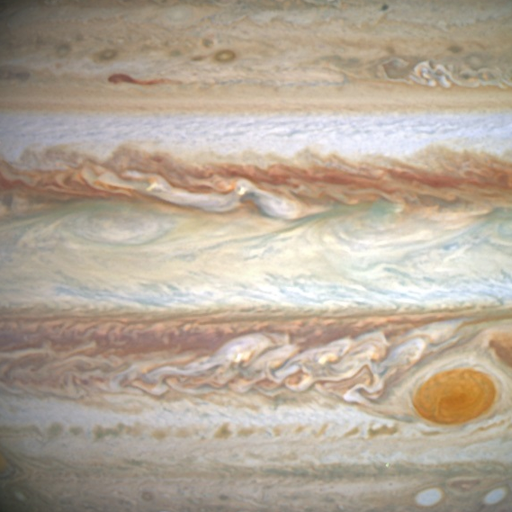

In [41]:
show(style_image)


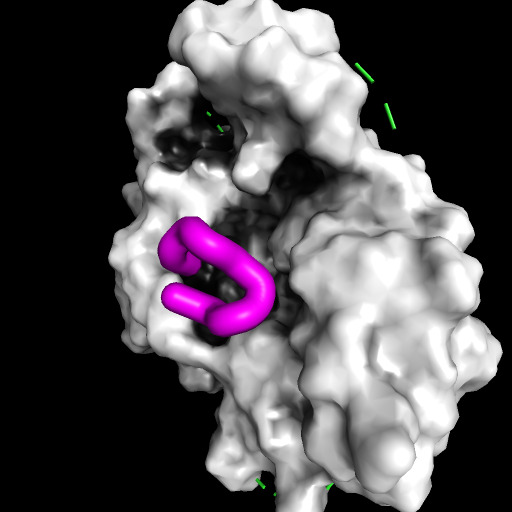

In [30]:
show(content_image)

In [13]:
assert tf.test.is_gpu_available(), 'No GPU!'

## Style transfer

This cell actually does the style transfer and will take a couple of minutes. 
The `thresholds` parameter will determine when the images are saved (and shown if `verbose=True`). e.g. if thresholds = `[512, 1024]` then `vis` will be a list
with two numpy arrays: the output after 512 training iterations and after 1024 iterations. 

Each numpy array has the shape `3 x 512 x 512 x 3`. The first dimension is whether it is the content/style/target image. The remaining dimensions are the regular image dimensions. 

In [42]:

param_f = lambda: style_transfer_param(content_image, style_image)

# set up objective functions
content_obj = content_weight * activation_difference(content_layers, 
                                                     difference_to=CONTENT_INDEX)
content_obj.description = "Content Loss"
style_obj = style_weight*activation_difference(style_layers, 
                                               transform_f=gram_matrix, 
                                               difference_to=STYLE_INDEX)
style_obj.description = "Style Loss"
objective = - content_obj - style_obj

# do learning
vis = render.render_vis(model, objective, param_f=param_f, thresholds=threshs, 
                        verbose=False)

## Save image

now we need to save the image and the numpy array if we want to do some post processing.  I've tried to create filenames that contain 
all the important hyper-parameters in them so that you can perform multiple iterations and easily see which file corresponds to which hyper-parameters. 

This is very hacky and if anyone has a better idea that's relatively simple (I can think of complicated solutions) I would love to hear it. 

In [43]:
# create filename
content_name = basename(content_path).split('.')[0]
style_name = basename(style_path).split('.')[0]
fname = '{0}__{1}__{2}__{3}__W{4:4.2f}__{5}__W{6:4.2f}__{7}'.format(model_name, 
                                                          content_name, 
                                                        style_name, 
                                                        content_layers, 
                                                        content_weight,  
                                                        style_layers, 
                                                        style_weight, 
                                                        style_tile)
fname = get_valid_filename(fname)
output_path = join(target_path, fname)

# save as array
np.save(arr=vis[-1], file=output_path+'.npy')

# save as image
tmp = np.concatenate(np.split(vis[-1], vis[-1].shape[0], axis=0), axis=2)[0, :, :, :]
tmp = (tmp*255).astype('uint8')
Image.fromarray(tmp).save(output_path+'.jpg')

In [16]:
print(output_path)

/content/drive/My Drive/art_of_md_2/images/target/InceptionV1__pymol_vis0001__Bosch__mixed3a__W100.00__mixed3a_mixed3b__W2.00__3


In [ ]:
show(tmp)